# Examining and thresholding sensitivity of a probe to the cortex using the Schaefer parcellation scheme

This notebook shows how to examine the theoretical sensitivity of a probe on a headmodel to brain areas (here we use parcel coordinates from the Schaefer 2018 atlas), and how to identify parcels that should be dropped, because changes in them cannot be observed. For this the original designed probe can also be reduced to an effective probe by dropping channels that are pruned due to bad signal quality.

In [150]:
# set this flag to True to enable interactive 3D plots
INTERACTIVE_PLOTS = False

In [ ]:
import pyvista as pv

import cedalion.sigproc

if INTERACTIVE_PLOTS:
    pv.set_jupyter_backend('html')
else:
    pv.set_jupyter_backend('static')

import os

import matplotlib.pyplot as p
import numpy as np
import xarray as xr
import pint
from IPython.display import Image

import cedalion
import cedalion.dataclasses as cdc
import cedalion_parcellation.datasets
import cedalion_parcellation.imagereco.forward_model as fw
import cedalion.imagereco.tissue_properties
import cedalion.sigproc.quality as quality
import cedalion.io
import cedalion.plots
import cedalion_parcellation.plots
from cedalion.vis import plot_sensitivity_matrix
from cedalion.imagereco.solver import pseudo_inverse_stacked
from cedalion import units
import cedalion.xrutils as xrutils

xr.set_options(display_expand_data=False)

#%matplotlib widget

# for dev purposes
#%load_ext autoreload
#%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load a DOT finger-tapping dataset
and perform some very basic quality checks to identify bad channels

In [152]:
# load example dataset
rec = cedalion_parcellation.datasets.get_fingertappingDOT()

# check signal quality using a simple SNR threshold
snr_thresh = 25 # the SNR (std/mean) of a channel. Set very high here for demonstration purposes

# SNR thresholding using the "snr" function of the quality subpackage
snr, snr_mask = quality.snr(rec["amp"], snr_thresh)

# drop channels with bad signal quality (here we only need the list of channels):
# prune channels using the masks and the operator "all", which will keep only channels that pass all three metrics
_, snr_ch_droplist = quality.prune_ch(rec["amp"], [snr_mask], "all")

# print list of dropped channels
print(f"{len(snr_ch_droplist)} channels pruned. List of pruned channels due to bad SNR: {snr_ch_droplist}")

mask collapsed to channel dimension
23 channels pruned. List of pruned channels due to bad SNR: ['S1D4' 'S1D5' 'S1D6' 'S1D8' 'S2D5' 'S2D6' 'S2D9' 'S4D2' 'S4D7' 'S4D13'
 'S5D6' 'S8D21' 'S8D22' 'S8D24' 'S9D21' 'S9D25' 'S10D21' 'S11D18' 'S11D20'
 'S12D19' 'S12D22' 'S12D28' 'S12D32']


## Load a headmodel and precalulated fluence profile

In [153]:
# load pathes to segmentation data for the icbm-152 atlas
SEG_DATADIR, mask_files, landmarks_file = cedalion_parcellation.datasets.get_icbm152_segmentation()
PARCEL_DIR = cedalion_parcellation.datasets.get_icbm152_parcel_file()

# create forward model class for icbm152 atlas
head = fw.TwoSurfaceHeadModel.from_surfaces(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    brain_surface_file= os.path.join(SEG_DATADIR, "mask_brain.obj"),
    scalp_surface_file= os.path.join(SEG_DATADIR, "mask_scalp.obj"),
    landmarks_ras_file=landmarks_file,
    parcel_file=PARCEL_DIR,
    brain_face_count=None,
    scalp_face_count=None
)

# snap probe to head and create forward model
geo3D_snapped = head.align_and_snap_to_scalp(rec.geo3d)
fwm = fw.ForwardModel(head, geo3D_snapped, rec._measurement_lists["amp"])


load precomputed fluce, calculate sensitivity on the cortex and plot it on head model

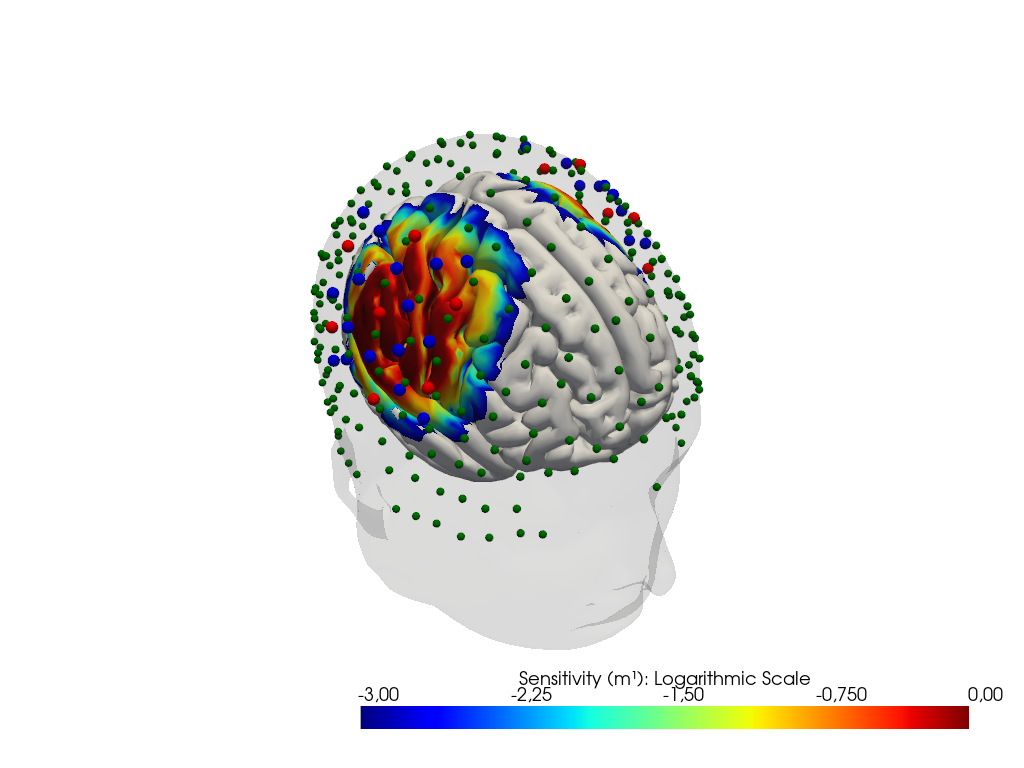

In [154]:
# load precomputed fluence for this dataset and headmodel
fluence_all, fluence_at_optodes = cedalion_parcellation.datasets.get_precomputed_fluence("fingertappingDOT", "icbm152")

# calculate Adot sensitivity matrix
Adot = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)

# plot on head model
plotter = plot_sensitivity_matrix.Main(
    sensitivity=Adot,
    brain_surface=head.brain,
    head_surface=head.scalp,
    labeled_points=geo3D_snapped,
)
plotter.plot(high_th=0, low_th=-3)
plotter.plt.show()

## Investigation of Parcels and effective Parcel Sensitivity
First plot full parcellation scheme on head

In [155]:
parcels = cedalion_parcellation.io.read_parcellations(PARCEL_DIR)

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


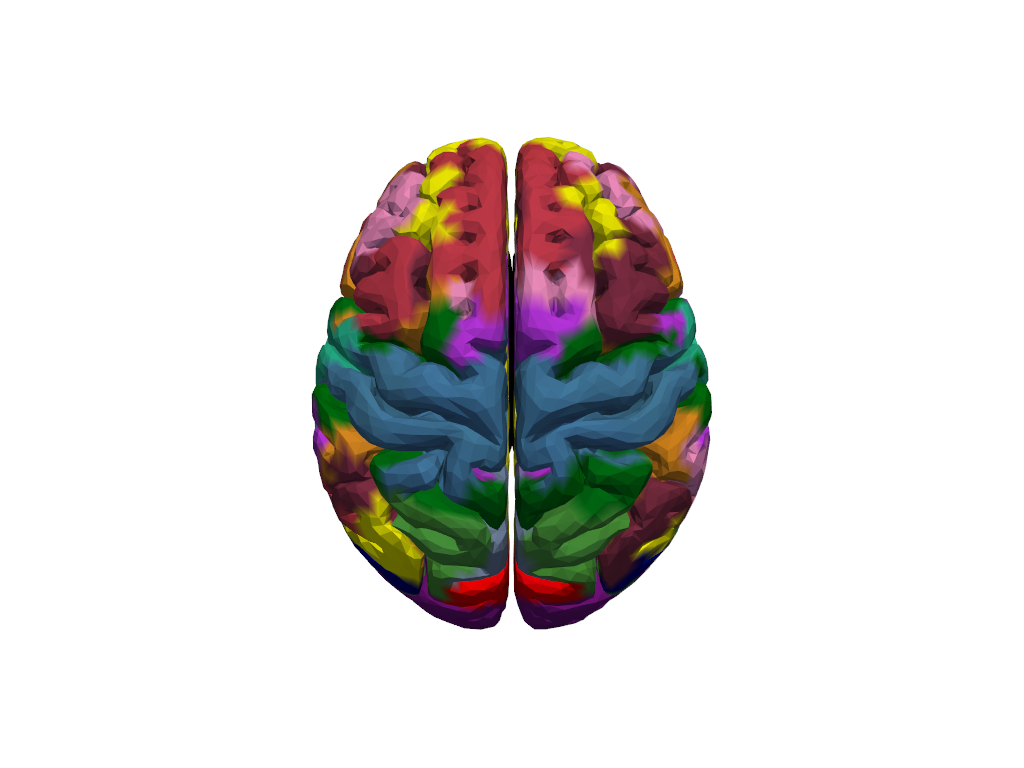

In [156]:
b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)
b["parcels"] = parcels.Color.tolist()

plt = pv.Plotter()

plt.add_mesh(
    b,
    scalars="parcels",
    rgb=True
)


if "parcel" in head.brain.vertices.coords:
    cog = head.brain.vertices.mean(["label", "parcel"]).values
else:
    cog = head.brain.vertices.mean("label").values
plt.camera.position = cog + [0,0,400]
plt.camera.focal_point = cog 
plt.camera.up = [0,1,0] 
plt.reset_camera()

plt.show()

### Calculate parcel sensitivity mask
 
 Parcels are considered good, if a change in HbO and HbR [µMol] in the parcel leads
     to an observable change of at least dOD in at least one wavelength of one channel.
     Sensitivities of all vertices in the parcel are summed up in the sensitivity matrix Adot.
     Bad channels in an actual measurement that are pruned can be considered by providing 
     a boolean channel_mask, where False indicates bad channels that are dropped 
     and not considered for parcel sensitivity. Requires headmodel with parcelation coordinates.

For this the following input arguments are used with parcel_sensitivity():
- Adot (channel, vertex, wavelength)): Sensitivity matrix with parcel coordinate belonging to each vertex
- chan_mask: boolean xarray DataArray channel mask, False for channels to be dropped
- dOD_thresh: threshold for minimum dOD change in a channel that should be observed from a hemodynamic change in a parcel
- minCh: minimum number of channels per parcel that should see a change above dOD_thresh
- dHbO: change in HbO concentration in the parcel in [µMol] used to calculate dOD
- dHbR: change in HbR concentration in the parcel in [µMol] used to calculate dOD

Output is a tuple (parcel_dOD, parcel_mask), where 
- parcel_dOD (channel, parcel) contains the delta OD observed in a channel given the assumed dHb change in a parcel, and 
- parcel_mask is a boolean DataArray with parcel coords from Adot that is true for parcels for which dOD_thresh is met. 

### Example without channel pruning

In [157]:
# set input parameters for parcel sensitivity calculation. 
# Here we do not (yet) drop bad channels to investigate the genereal 
# sensitivity of the probe to parcel space independent of channel quality

dOD_thresh = 0.01
minCh = 1 
dHbO = 10 #µMol
dHbR = -3 #µMol

parcel_dOD, parcel_mask = quality.parcel_sensitivity(
    Adot, None, dOD_thresh, minCh, dHbO, dHbR
)

# display results
display(parcel_dOD)
display(parcel_mask)

# fetch parcels from the parcel_mask that are above the threshold to a list of parcel names
sensitive_parcels = parcel_mask.where(parcel_mask, drop=True)["parcel"].values.tolist()
dropped_parcels = parcel_mask.where(~parcel_mask, drop=True)["parcel"].values.tolist()
print(f"Number of sensitive parcels: {len(sensitive_parcels)}")
print(f"Number of dropped parcels: {len(dropped_parcels)}")

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Magnitude,[[4.891882648776717e-08 5.840091165898684e-12 4.785420498433055e-13 ... 6.442581218925999e-18 2.6241067374712174e-19 1.6489303258527585e-19] [6.043658210891901e-10 2.8328930752152125e-13 1.8221662131580694e-12 ... 2.680649786594407e-18 1.2110645151639198e-19 1.3474522125014807e-18] [3.001746676015518e-09 2.850851715497861e-13 1.8352102569319e-13 ... 6.3455036906722026e-18 1.561281227884762e-19 6.73970884479603e-20] ... [3.7628816998587176e-13 9.67100188938551e-13 1.9002502397063616e-13 ... 9.091492408600361e-14 6.821822473558e-13 4.111206527310888e-13] [6.385562444928774e-14 3.184318522679466e-12 2.4659301415132837e-14 ... 3.443874716879725e-14 1.3225470504325321e-11 1.5967202436306775e-13] [7.897002294374222e-13 1.134524236231651e-12 2.70924910623092e-13 ... 3.5813709434490176e-13 1.1598070474589022e-12 1.5101017551548718e-12]]
Units,1/millimeter


<xarray.DataArray (parcel: 602)> Size: 602B
False False False False False False True ... False False False False False False
Coordinates:
  * parcel   (parcel) object 5kB 'Background+FreeSurfer_Defined_Medial_Wall_L...

Number of sensitive parcels: 40
Number of dropped parcels: 562


visualize results

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\avonl\AppData\Local\Temp\ipykernel_33580\447309769.py:3: RuntimeWarning: divide by zero encountered in log10
  p.imshow(np.log10(parcel_dOD.values), aspect="auto")


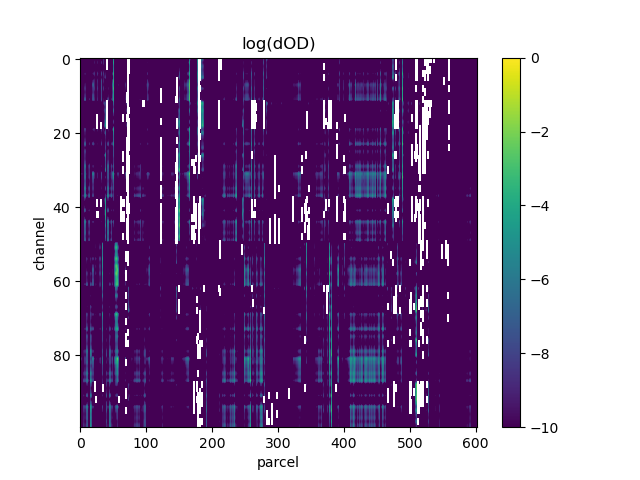

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


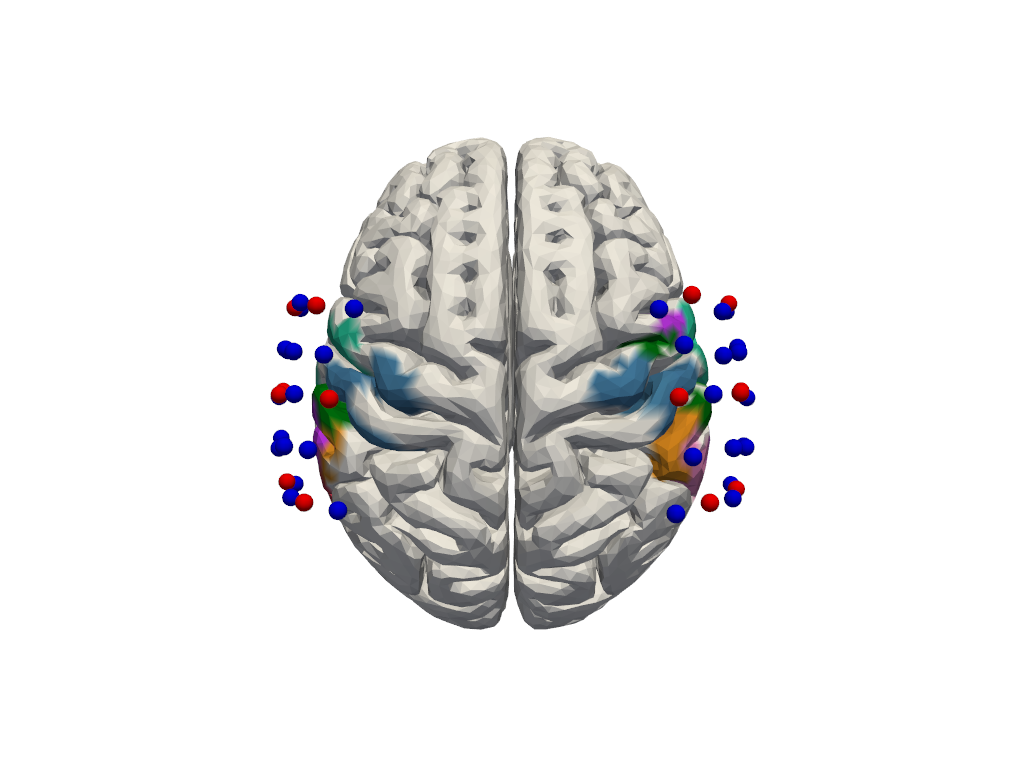

In [158]:
# plots a surface plot of dOD with axes "channel" and "parcel" using the log of the values in dOD on the z-axis with a color bar limit from -10 to 0
p.figure()
p.imshow(np.log10(parcel_dOD.values), aspect="auto")
p.clim(-10, 0)
p.colorbar()
p.xlabel("parcel")
p.ylabel("channel")
p.title("log(dOD)")
p.show()



# reduce parcel set to plot to the sensitive parcels
# Find mask of rows to update
mask = parcels["Label"].isin(dropped_parcels)
# Use .loc with .apply to set the Color column per row
parcels_plotsens = parcels.copy()
parcels_plotsens.loc[mask, "Color"] = parcels_plotsens.loc[mask, "Color"].apply(lambda _: [1, 1, 1])


b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)
b["parcels"] = parcels_plotsens.Color.tolist()

plt = pv.Plotter()
plt.add_mesh(
    b,
    scalars="parcels",
    rgb=True
)

if "parcel" in head.brain.vertices.coords:
    cog = head.brain.vertices.mean(["label", "parcel"]).values
else:
    cog = head.brain.vertices.mean("label").values
plt.camera.position = cog + [0,0,400]
plt.camera.focal_point = cog 
plt.camera.up = [0,1,0] 
plt.reset_camera()
# add probe
geo3D_snapped_o = geo3D_snapped.where(geo3D_snapped.label.str.contains("S|D"), drop=True)
cedalion.plots.plot_labeled_points(plt, geo3D_snapped_o)
plt.show()


### Example with channel pruning
The same as before, but now we consider a list of "bad" channels that should be excluded from the sensitivity consideration

In [159]:
# set input parameters for parcel sensitivity calculation. 
# Now we use the snr channel mask to exclude channels with bad signal quality 
# (here artificially high threshold) from consideration for parcel sensitivity

dOD_thresh = 0.01
minCh = 1 
dHbO = 10 #µMol
dHbR = -3 #µMol
chan_droplist = snr_ch_droplist # list of dropped channels due to bad SNR, effectively reducing probe


parcel_dOD, parcel_mask = quality.parcel_sensitivity(
    Adot, chan_droplist, dOD_thresh, minCh, dHbO, dHbR
)

# display results
display(parcel_dOD)
display(parcel_mask)

# fetch parcels from the parcel_mask that are above the threshold to a list of parcel names
sensitive_parcels = parcel_mask.where(parcel_mask, drop=True)["parcel"].values.tolist()
dropped_parcels = parcel_mask.where(~parcel_mask, drop=True)["parcel"].values.tolist()
print(f"Number of sensitive parcels: {len(sensitive_parcels)}")
print(f"Number of dropped parcels: {len(dropped_parcels)}")

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Magnitude,[[4.891882648776717e-08 5.840091165898684e-12 4.785420498433055e-13 ... 6.442581218925999e-18 2.6241067374712174e-19 1.6489303258527585e-19] [6.043658210891901e-10 2.8328930752152125e-13 1.8221662131580694e-12 ... 2.680649786594407e-18 1.2110645151639198e-19 1.3474522125014807e-18] [0.0 0.0 0.0 ... 0.0 0.0 0.0] ... [3.7628816998587176e-13 9.67100188938551e-13 1.9002502397063616e-13 ... 9.091492408600361e-14 6.821822473558e-13 4.111206527310888e-13] [6.385562444928774e-14 3.184318522679466e-12 2.4659301415132837e-14 ... 3.443874716879725e-14 1.3225470504325321e-11 1.5967202436306775e-13] [7.897002294374222e-13 1.134524236231651e-12 2.70924910623092e-13 ... 3.5813709434490176e-13 1.1598070474589022e-12 1.5101017551548718e-12]]
Units,1/millimeter


<xarray.DataArray (parcel: 602)> Size: 602B
False False False False False False True ... False False False False False False
Coordinates:
  * parcel   (parcel) object 5kB 'Background+FreeSurfer_Defined_Medial_Wall_L...

Number of sensitive parcels: 27
Number of dropped parcels: 575


visualize results

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\avonl\AppData\Local\Temp\ipykernel_33580\1274119056.py:3: RuntimeWarning: divide by zero encountered in log10
  p.imshow(np.log10(parcel_dOD.values), aspect="auto")


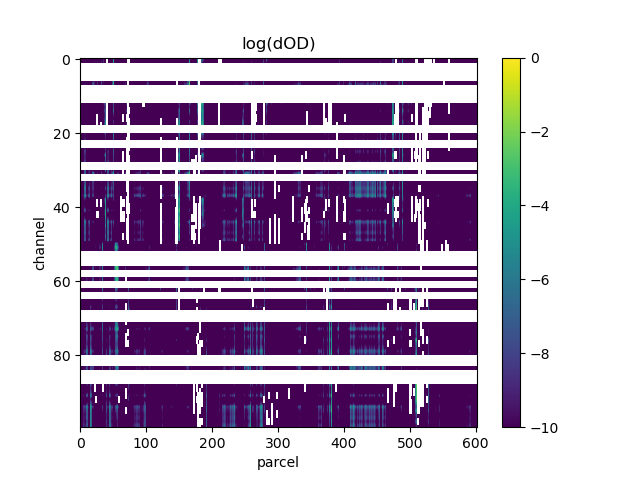

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


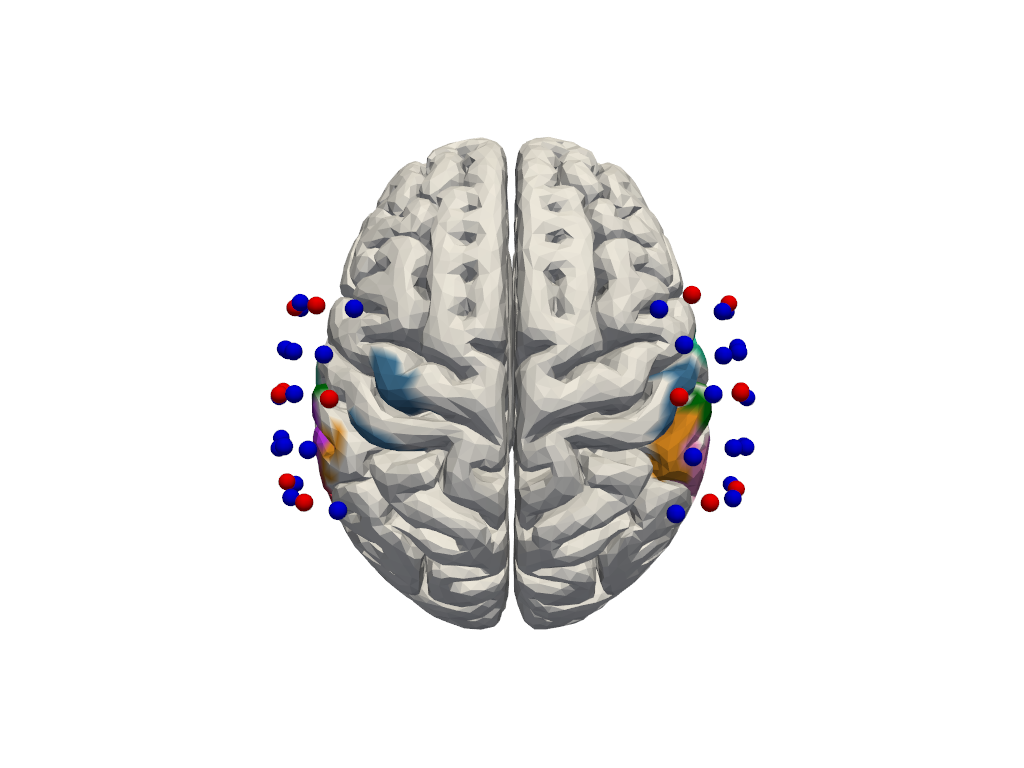

In [160]:
# plots a surface plot of dOD with axes "channel" and "parcel" using the log of the values in dOD on the z-axis with a color bar limit from -10 to 0
p.figure()
p.imshow(np.log10(parcel_dOD.values), aspect="auto")
p.clim(-10, 0)
p.colorbar()
p.xlabel("parcel")
p.ylabel("channel")
p.title("log(dOD)")
p.show()



# reduce parcel set to plot to the sensitive parcels
# Find mask of rows to update
mask = parcels["Label"].isin(dropped_parcels)
# Use .loc with .apply to set the Color column per row
parcels_plotsens = parcels.copy()
parcels_plotsens.loc[mask, "Color"] = parcels_plotsens.loc[mask, "Color"].apply(lambda _: [1, 1, 1])

b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)
b["parcels"] = parcels_plotsens.Color.tolist()

plt = pv.Plotter()
plt.add_mesh(
    b,
    scalars="parcels",
    rgb=True
)

if "parcel" in head.brain.vertices.coords:
    cog = head.brain.vertices.mean(["label", "parcel"]).values
else:
    cog = head.brain.vertices.mean("label").values
plt.camera.position = cog + [0,0,400]
plt.camera.focal_point = cog 
plt.camera.up = [0,1,0] 
plt.reset_camera()
# add probe
geo3D_snapped_o = geo3D_snapped.where(geo3D_snapped.label.str.contains("S|D"), drop=True)
cedalion.plots.plot_labeled_points(plt, geo3D_snapped_o)
plt.show()

